In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests
import zipfile
import io
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)
%matplotlib inline
import seaborn as sns

In [2]:
r_p_pre = pd.read_csv('../data/nyc_building_sales.csv', index_col=0)

C:\Users\Alex\Anaconda3\envs\nyc-buildings\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,23,25,27,28,70) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There is a lot to do to get this data normalized into something usable.

Let's start by filtering out **non-sales**. These come in two forms: sales which are really just **property transfers**, for some tiny amount of money, and sales which are part of larger contracts, making them **non-market sales**.

**Note**: This is pared-down redoing of an earlier notebook that I did on this subject which was lost when I accidentally busted the USB drive it was on.

Drawing the line is hard. But we can start by eliminating the vast number of obviously not-real sales. Taking out everything under $1000 will do nicely (there's a lot of these, as shown below).

In [3]:
(r_p_pre['MarketValueSqFt'] == 0).value_counts()

False    27007
True     13215
Name: MarketValueSqFt, dtype: int64

In [4]:
r_p_pre = r_p_pre[r_p_pre['SalePrice'] > 1000]

We expect the true value of the building to be somewhat close to the approximate value calculated by the city. In reality there are a lot of cases where this public figure is as much 50% off or even 100% off, but after a certain point the source of the error becomes not the city's mis-assessment but a below-market-value sale on the part of the selling parties.

Here are the ten worst offenders, for example:

In [5]:
r_p_pre.sort_values(by = 'SalePrice', ascending=False).tail(10)[::-1][['SalePrice', 'Address', 'AssessmentValueSqFt',
                                                                       'EstPriorMarketValueSqFt',
                                                                       'EstCurentMarketValueSqFt', 'MarketValueSqFt']]

,SalePrice,Address,AssessmentValueSqFt,EstPriorMarketValueSqFt,EstCurentMarketValueSqFt,MarketValueSqFt
Index,,,,,,
4931,1908.0,314 42 STREET,122.914889,273.144198,288.395904,0.101749
131,2000.0,312 EAST 164 STREET,4.353750,268.125000,249.375000,1.250000
33563,2500.0,ALONZO ROAD,8.452500,487.500000,502.500000,6.250000
6241,2800.0,225 ROCKAWAY AVENUE,1.753771,111.236802,133.484163,1.055807
34891,2900.0,1268 FOREST AVENUE,73.369565,163.043478,135.011442,0.553013
29401,3000.0,168-19 110 AVENUE,13.337148,306.338028,407.570423,2.640845
6571,3050.0,434 KOSCIUSZKO STREET,4.598148,251.851852,278.148148,1.129630
4797,4000.0,158 DIKEMAN STREET,39.461538,87.692308,97.179487,1.025641
4396,4000.0,268 WEST 261 STREET,19.402500,765.000000,780.000000,10.000000


A couple K wouldn't buy you a good used car, let alone a house. We already earlier filtered out the bulk of the in-family or contractual transfers by specifying a lower real estate limit of 1000$. However this wasn't an aggressive enough culling to deal with cases in which the house was sold for real money, just not real house money, for whatever reason.

On the other end of the spectrum, property with a high value (especially skyscrapers) tend to be worth more than city estimates:

In [6]:
r_p_pre.sort_values(by = 'SalePrice', ascending=False).head(10)[['SalePrice', 'Address', 'AssessmentValueSqFt',
                                                                       'EstPriorMarketValueSqFt',
                                                                       'EstCurentMarketValueSqFt', 'MarketValueSqFt']]

,SalePrice,Address,AssessmentValueSqFt,EstPriorMarketValueSqFt,EstCurentMarketValueSqFt,MarketValueSqFt
Index,,,,,,
18164,4.111112e+09,240 1 AVENUE,63.683057,141.517903,152.106378,459.744000
18170,1.932900e+09,787 7 AVENUE,199.678147,443.729216,466.975297,1179.577905
17637,1.767913e+09,235 WEST STREET,94.910921,210.913158,678.919737,2326.201466
18171,1.649000e+09,1285 AVENUE OF THE AMER,171.113526,380.252279,385.552176,1021.782114
18342,1.400000e+09,550 MADISON AVENUE,239.747984,532.773298,536.312080,1691.462704
18165,1.345485e+09,342 1 AVENUE,52.986645,117.748101,132.112492,430.946160
18341,5.250000e+08,693 5 AVENUE,296.837711,659.639357,665.097366,5181.653984
18347,4.630000e+08,850 3 AVENUE,117.989385,262.198634,283.570714,805.672772
18374,4.530000e+08,885 3 AVENUE,193.085550,429.079000,462.367823,817.423942


Here's a rank distribution of over and under -estimates.

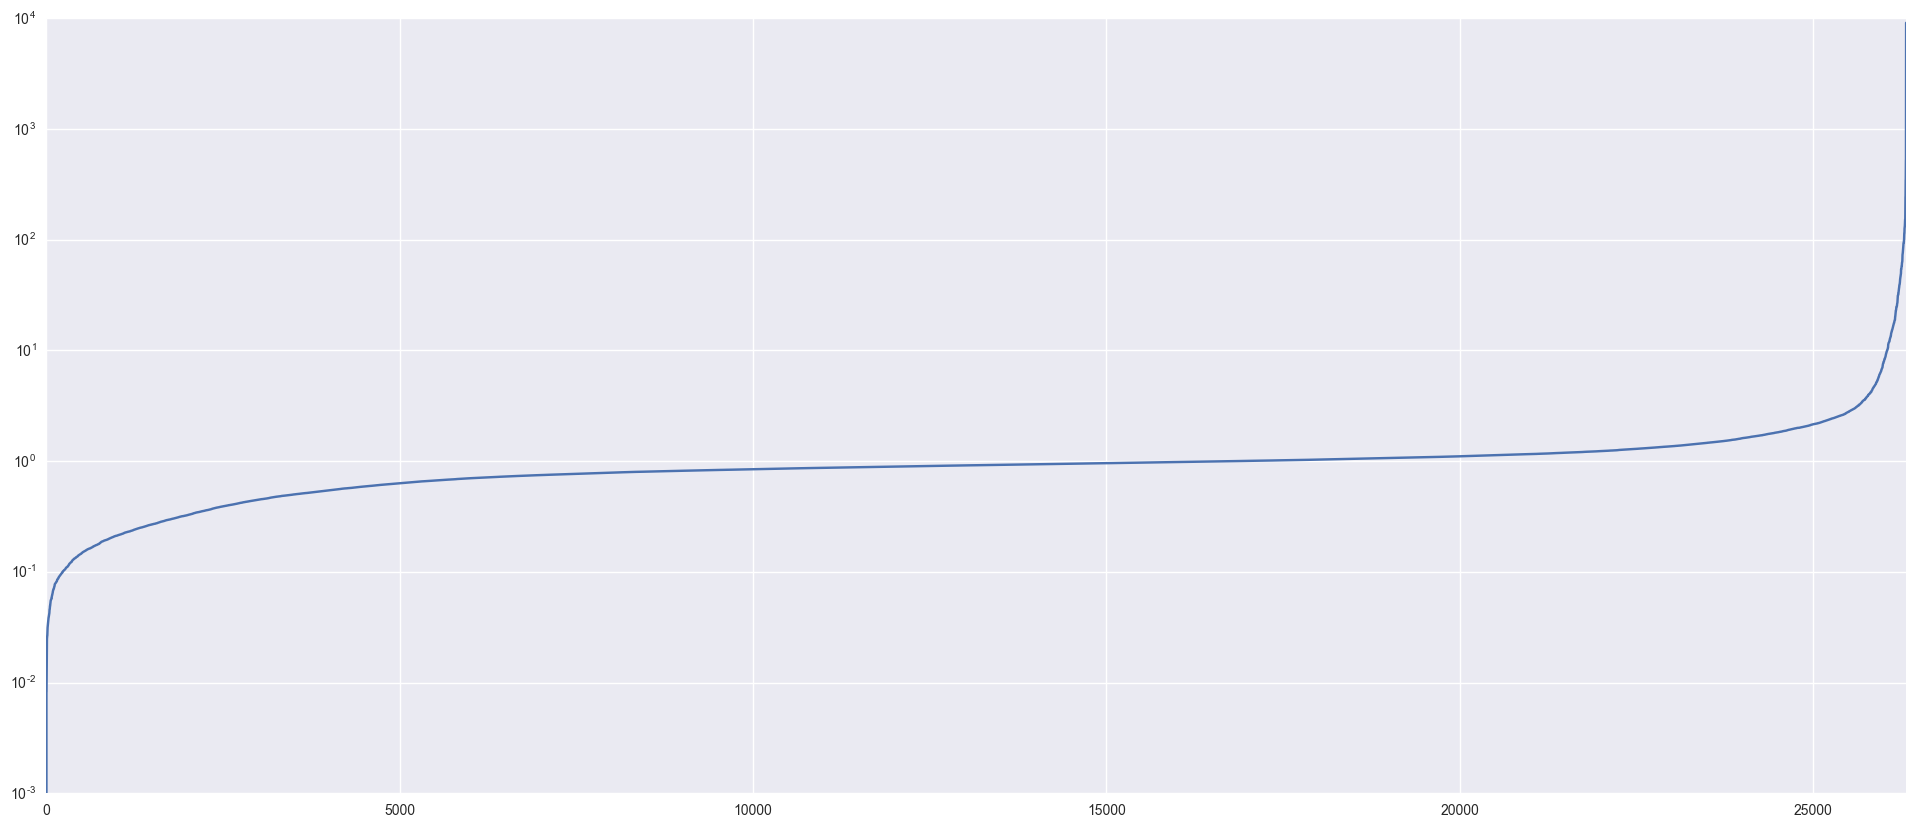

In [7]:
m_ratio = (r_p_pre['EstCurentMarketValueSqFt'] / r_p_pre['MarketValueSqFt']).sort_values().reset_index(drop=True)
m_ratio.plot(logy=True, figsize=(24, 10))

What percentage of records are accurate to within plus/minus 25%?

In [8]:
len(m_ratio[(m_ratio > 0.75) & (m_ratio < 1.25)]) / len(m_ratio)

0.5751852555576668

There we go&mdash;a number to try and beat.

Here's a plot of market value versus predicted value ranked by market value:

A little more information about our dataset before we select a band: is under to over -estimation somehow correlated with actual market value, as I assume is the case (it's easier to be wrong about a big building than a small one)?

C:\Users\Alex\Anaconda3\envs\nyc-buildings\lib\site-packages\matplotlib\scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


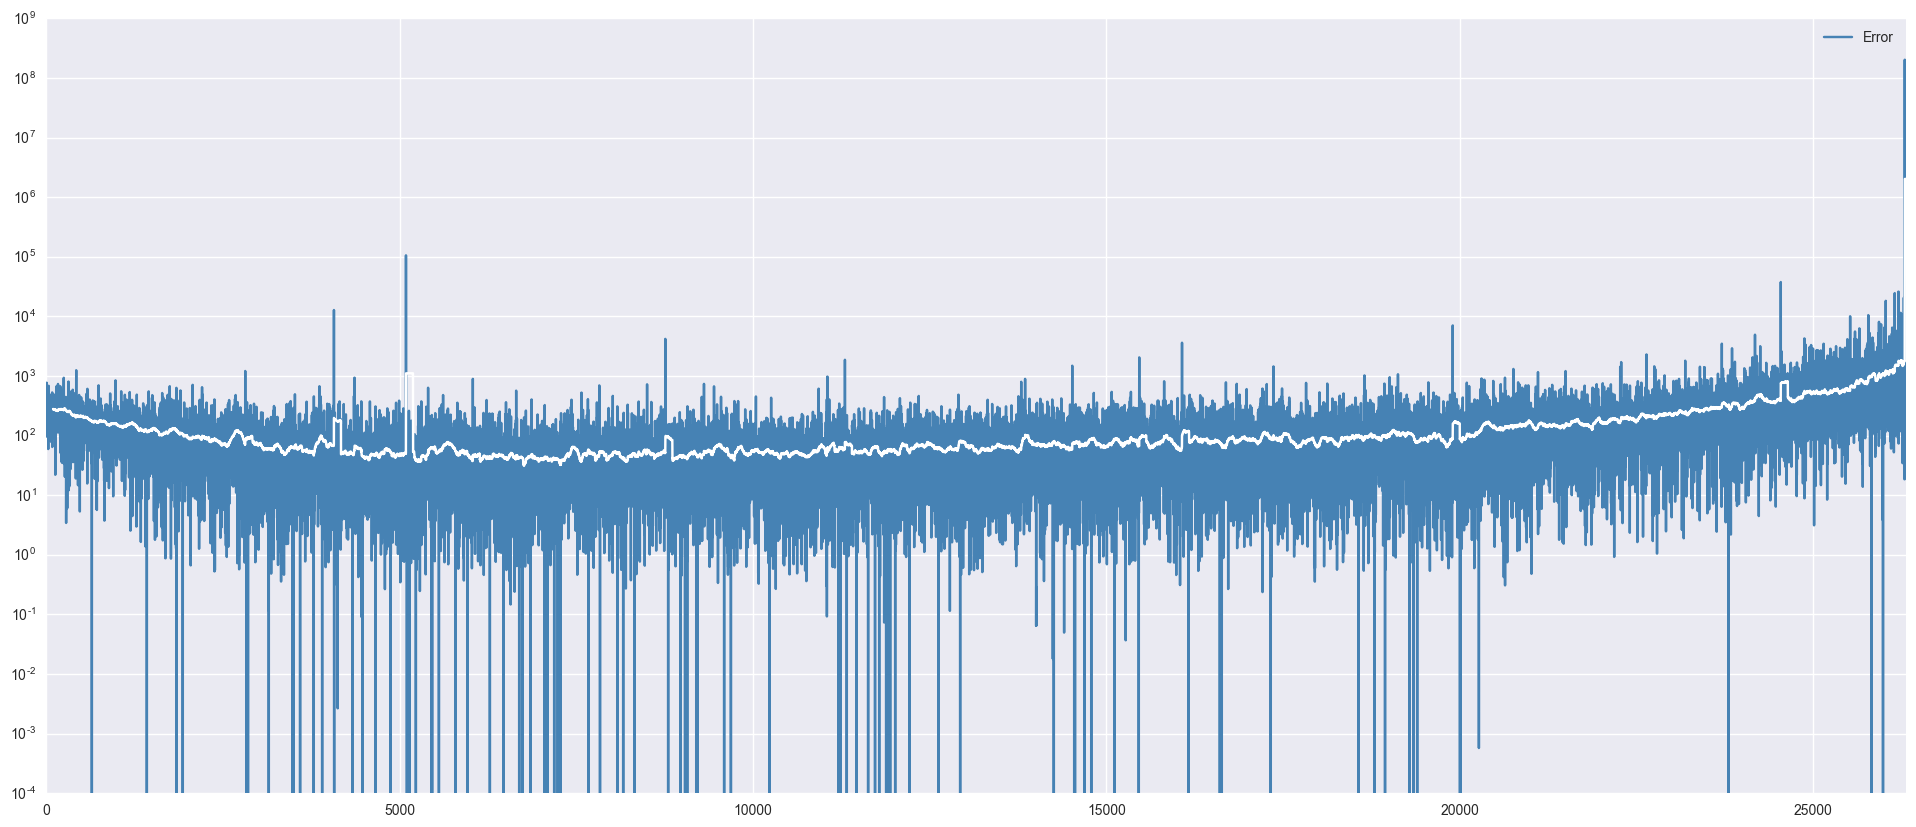

In [9]:
r_p_pre_s = r_p_pre.copy()
r_p_pre_s['ValueRatio'] = r_p_pre['EstCurentMarketValueSqFt'] / r_p_pre['MarketValueSqFt']
r_p_pre_s['Error'] = np.abs(r_p_pre['EstCurentMarketValueSqFt'] - r_p_pre['MarketValueSqFt'])
axes = r_p_pre_s.sort_values(by='SalePrice').reset_index().plot(figsize=(24, 10), y='Error', logy=True, color='steelblue')
rolling = r_p_pre_s.sort_values(by='SalePrice').reset_index()['Error'].rolling(center=False, window=100).mean()
rolling.plot(ax=axes, color='white')

This plot shows the absolute difference between expected and actual market value per square foot.

As expected, the city's model does best when predicting intermediate varibles, and low and high values cause the error to rise. If things seem flat, they're not: remember that this is a logorithmic plot (the additional plot below demonstrates what I mean&mdash;and it only fits on the axis by not attempting to fit the 250 largest-value sales!).

This means that there are two sources of strong systemic error in the city's model. The first is error on the lowest-value sales, which, as previously discussed, come about as a result of non-market sales. The second is error on the highest-value sales, which comes from the model performing very poorly when attempting to price skyscrapers.

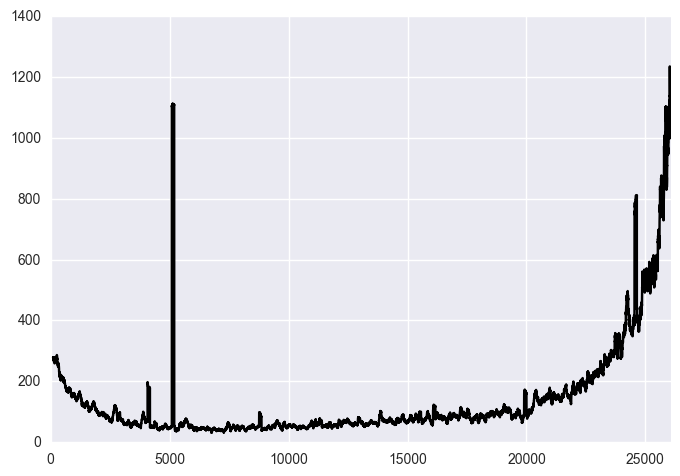

In [10]:
rolling[:-250].plot(color='black')

Looking at a wrongness ratio:

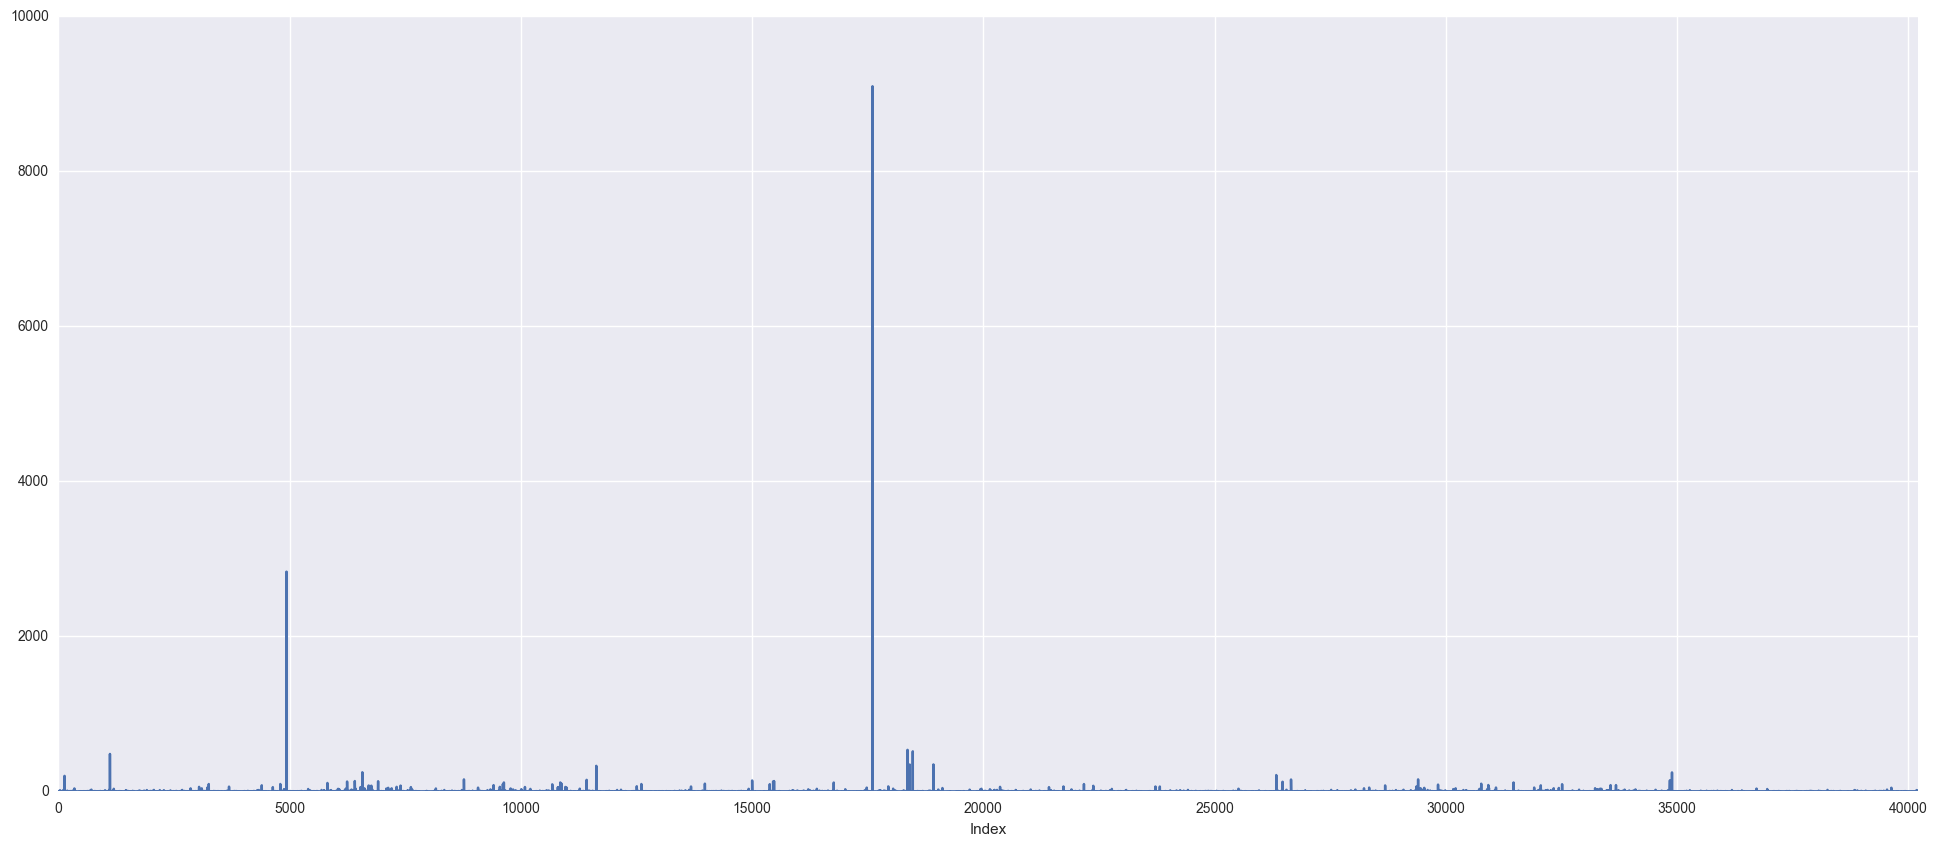

In [11]:
(r_p_pre_s['ValueRatio']).plot(figsize=(24, 10))

This doesn't make picking a good cutoff easier; mostly it just shows that there are some really extreme outliers out there. At what point do we stop losing missinformation and start losing the real thing? One more look to decide...

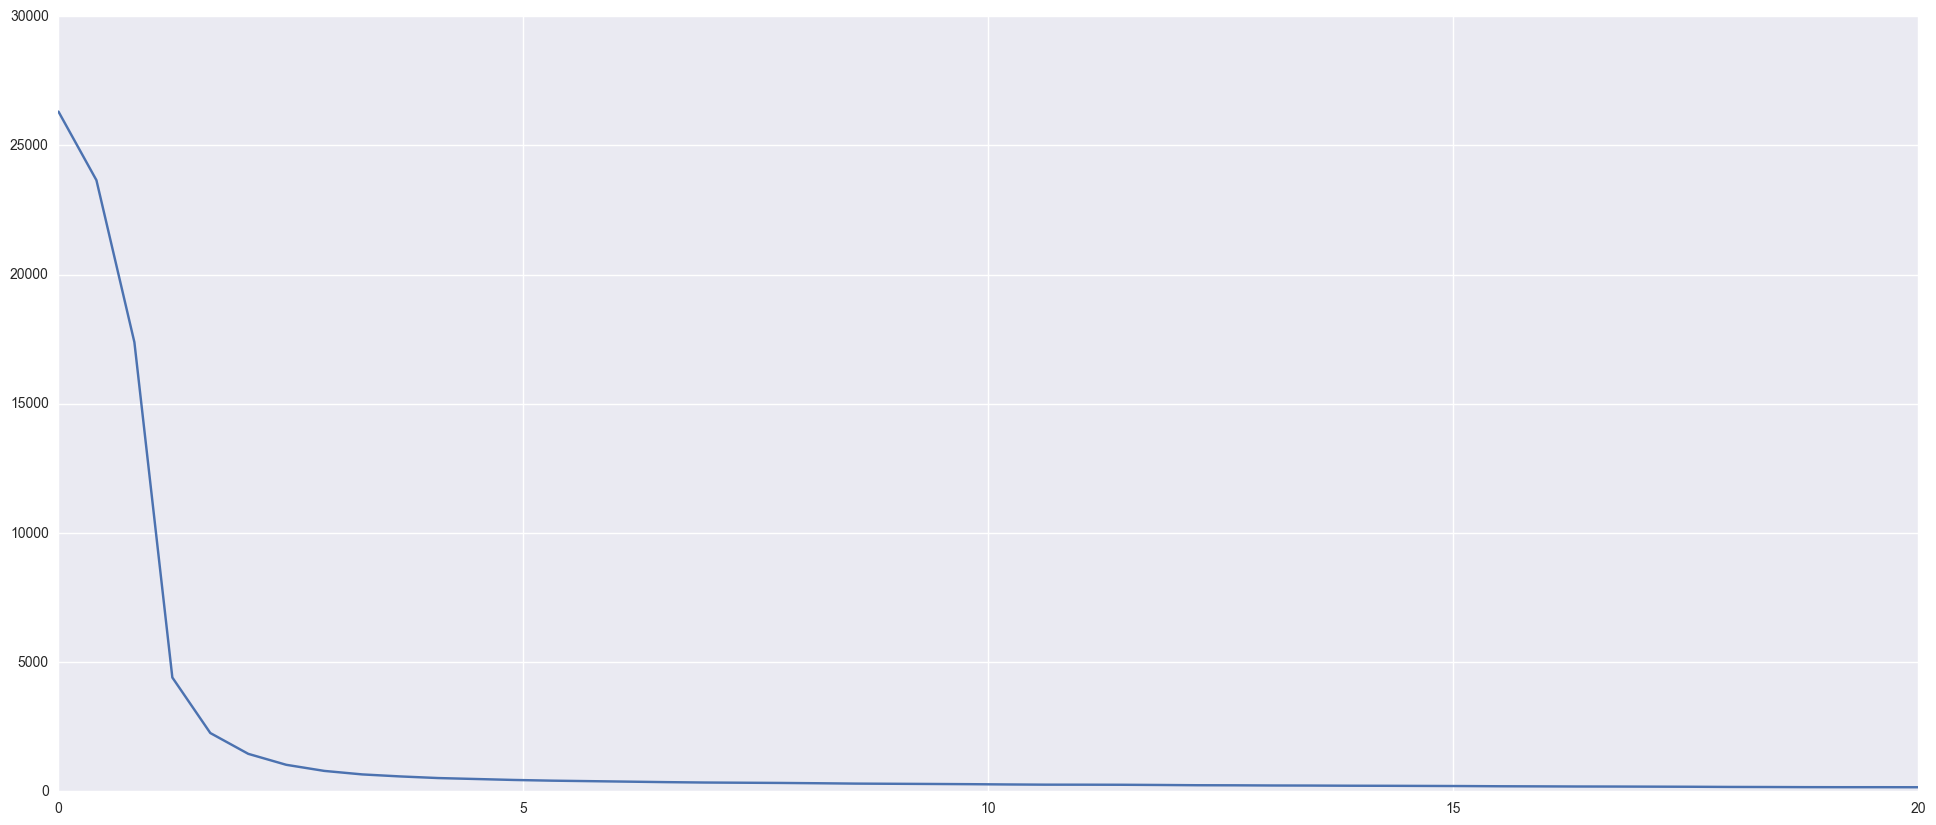

In [12]:
pd.Series({n: len(r_p_pre_s[r_p_pre_s['ValueRatio'] > n]) for n in np.linspace(0, 20)}).plot(figsize=(24, 10))

In [13]:
r_p_pre_s['OffRatio'] =  ((np.abs(r_p_pre_s['EstCurentMarketValueSqFt'] - r_p_pre_s['MarketValueSqFt'])) / r_p_pre_s['MarketValueSqFt'])

I decided to be very liberal and band at 95 percent of the data. I am doing so because of a bunch of analytics that I ran in the now-lost notebook which show that a model built on the middle of the market will generalize well to the market's extreme cases, or perhaps rather that there is no chance of generalizing to those extreme cases even if it does not, so we don't lose anything by being very strict about the data we accept.

We'll cut off at `'OffRatio' = 2`.

In [14]:
len(r_p_pre_s[r_p_pre_s['ValueRatio'] > 2]) / len(r_p_pre_s)

0.057533726011780355

In [15]:
r_p_pre_s['ValueRatio']

Index
0        0.079833
2        1.408000
4        0.563218
5        0.911111
6        0.365970
7        0.219422
9        0.748437
10       0.455000
11       1.064542
12       0.670000
           ...   
40208    1.366224
40210    0.831765
40211    0.437853
40213    0.827657
40214    1.390947
40215    1.210938
40218    0.854069
40219    1.034646
40220    2.186513
40221    0.953448
Name: ValueRatio, dtype: float64

In [16]:
r_p_pre_ss = r_p_pre_s[r_p_pre_s['ValueRatio'] < 2]

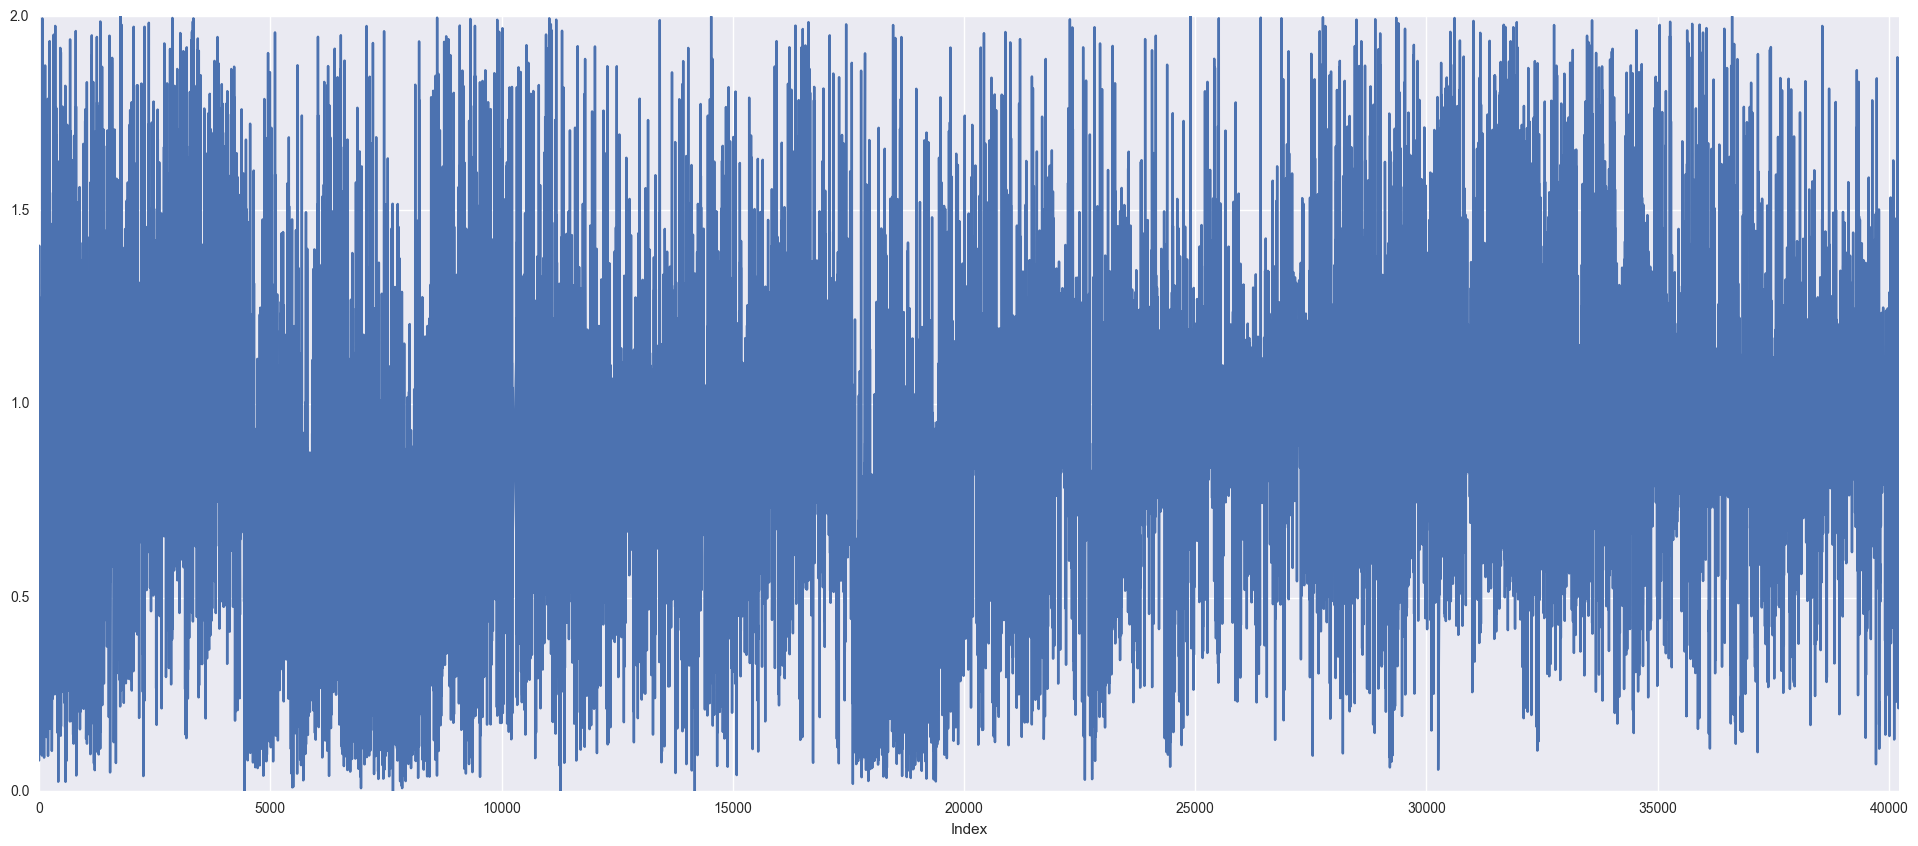

In [17]:
(r_p_pre_ss['ValueRatio']).plot(figsize=(24, 10))

In [18]:
len(r_p_pre_s)

26315

In [19]:
len(r_p_pre_ss)

24787

Looking at the plot again afterwards:

C:\Users\Alex\Anaconda3\envs\nyc-buildings\lib\site-packages\matplotlib\scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


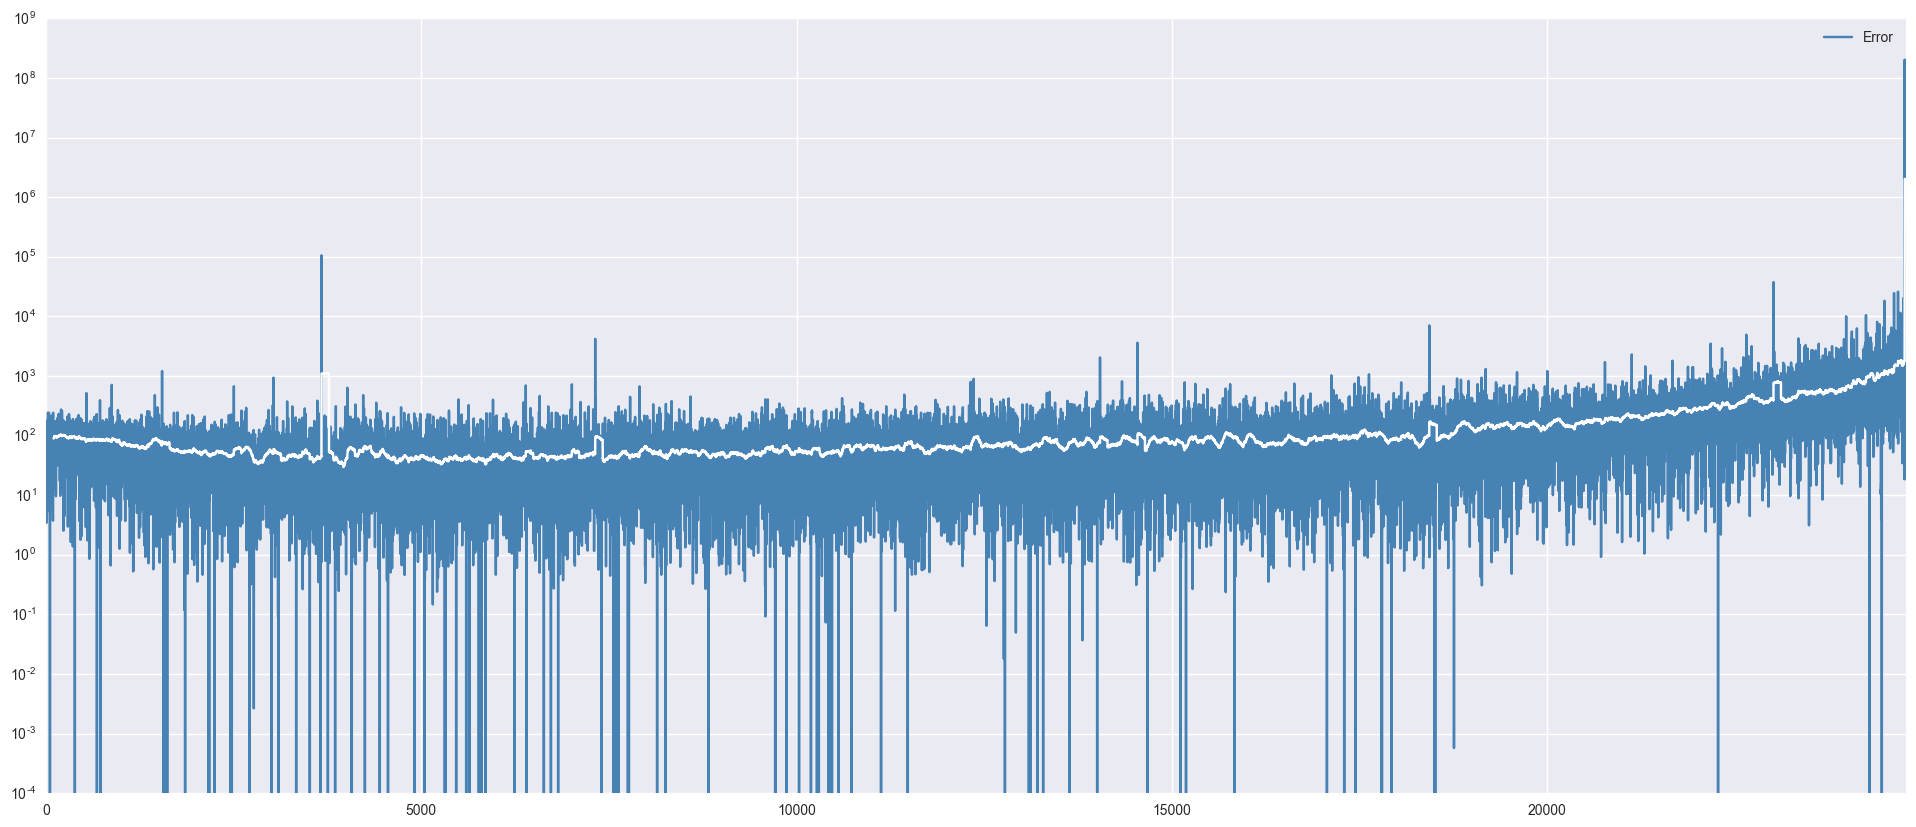

In [20]:
axes_2 = r_p_pre_ss.sort_values(by='SalePrice').reset_index().plot(figsize=(24, 10), y='Error', logy=True, color='steelblue')
rolling_2 = r_p_pre_ss.sort_values(by='SalePrice').reset_index()['Error'].rolling(center=False, window=100).mean()
rolling_2.plot(ax=axes_2, color='white')

It looks the same. Good!

Doing the same thing in the other direction would cause a heckuva lot of data loss:

In [21]:
r_p_pre_ss['RValueRatio'] = r_p_pre['MarketValueSqFt'] / r_p_pre['EstCurentMarketValueSqFt']

C:\Users\Alex\Anaconda3\envs\nyc-buildings\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [22]:
r_p_pre_ss['RValueRatio']

Index
0        12.526096
2         0.710227
4         1.775510
5         1.097561
6         2.732468
7         4.557432
9         1.336117
10        2.197802
11        0.939372
12        1.492537
           ...    
40207     4.662208
40208     0.731944
40210     1.202263
40211     2.283871
40213     1.208229
40214     0.718935
40215     0.825806
40218     1.170866
40219     0.966514
40221     1.048825
Name: RValueRatio, dtype: float64

In [23]:
len(r_p_pre_ss[r_p_pre_ss['RValueRatio'] > 2]) / len(r_p_pre_ss)

0.14124339371444708

Why? We'll explore that in a bit.

(0, 5000)

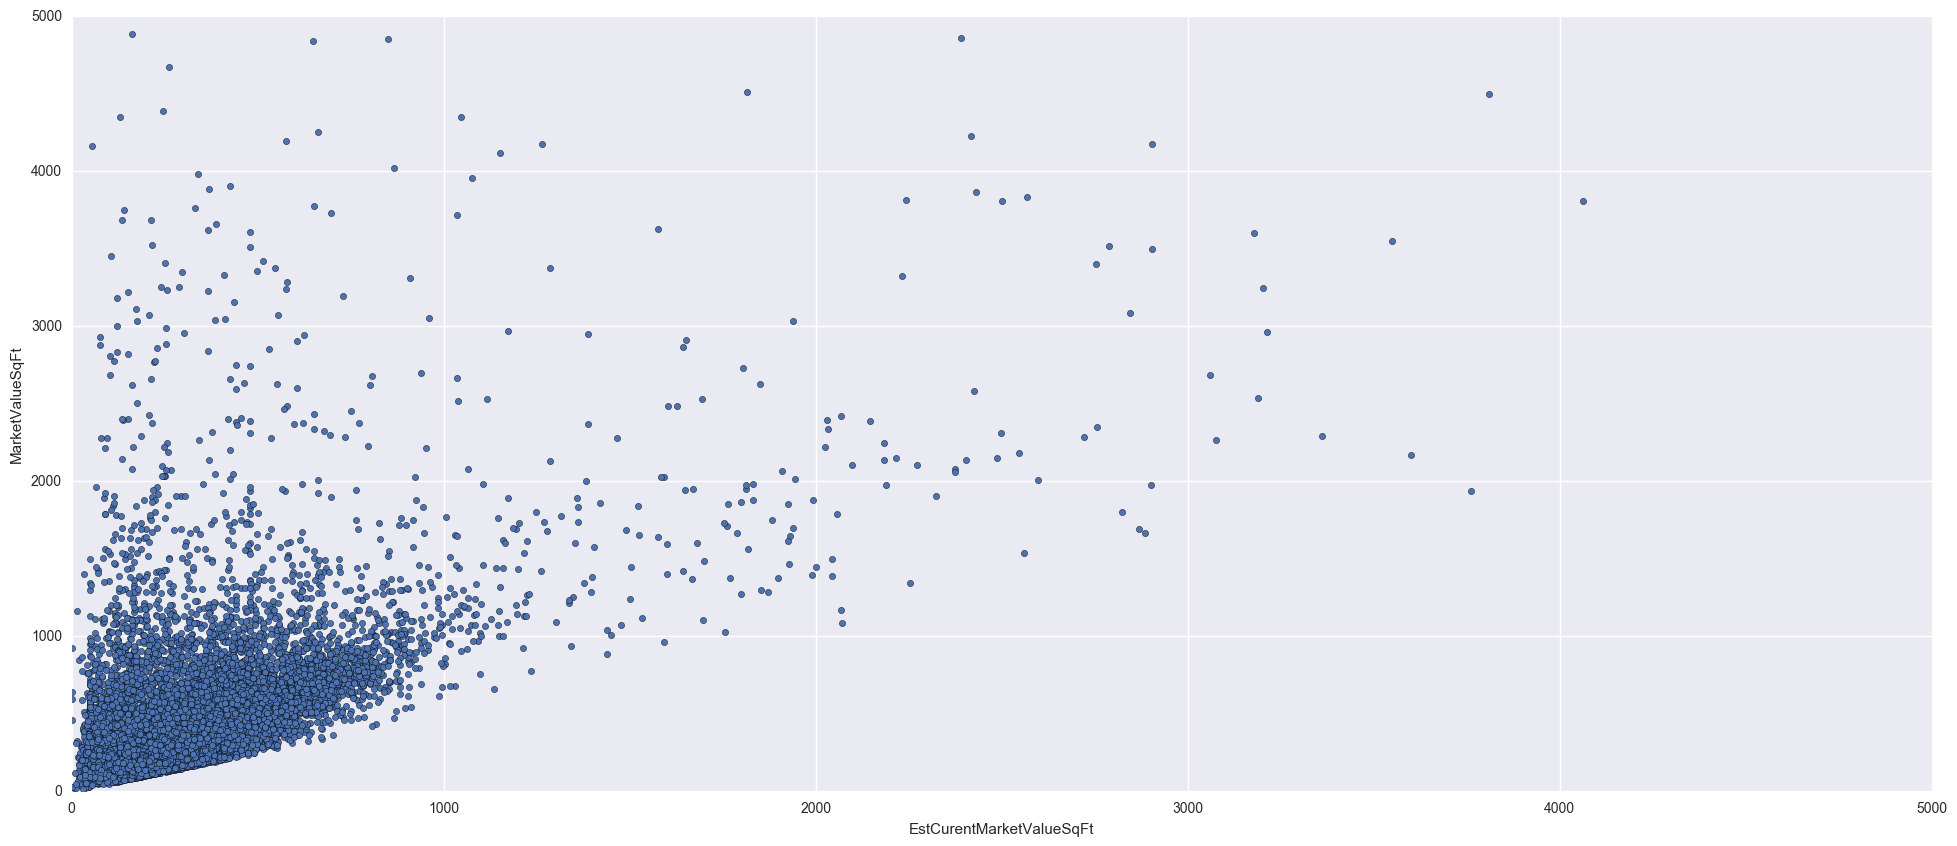

In [24]:
ax = r_p_pre_ss[r_p_pre_ss['MarketValueSqFt'] < 10000][['MarketValueSqFt', 'EstCurentMarketValueSqFt']].plot(y='MarketValueSqFt',
                                                                                               x='EstCurentMarketValueSqFt',
                                                                                               kind='scatter',
                                                                                               figsize=(24, 10))
ax.set_xlim([0,5000])
ax.set_ylim([0,5000])

Box, box, box the data!

In [25]:
r_p_pre_ss = r_p_pre_ss[r_p_pre_ss['EstCurentMarketValueSqFt'] < 1000]
r_p_pre_ss = r_p_pre_ss[r_p_pre_ss['MarketValueSqFt'] < 1000]

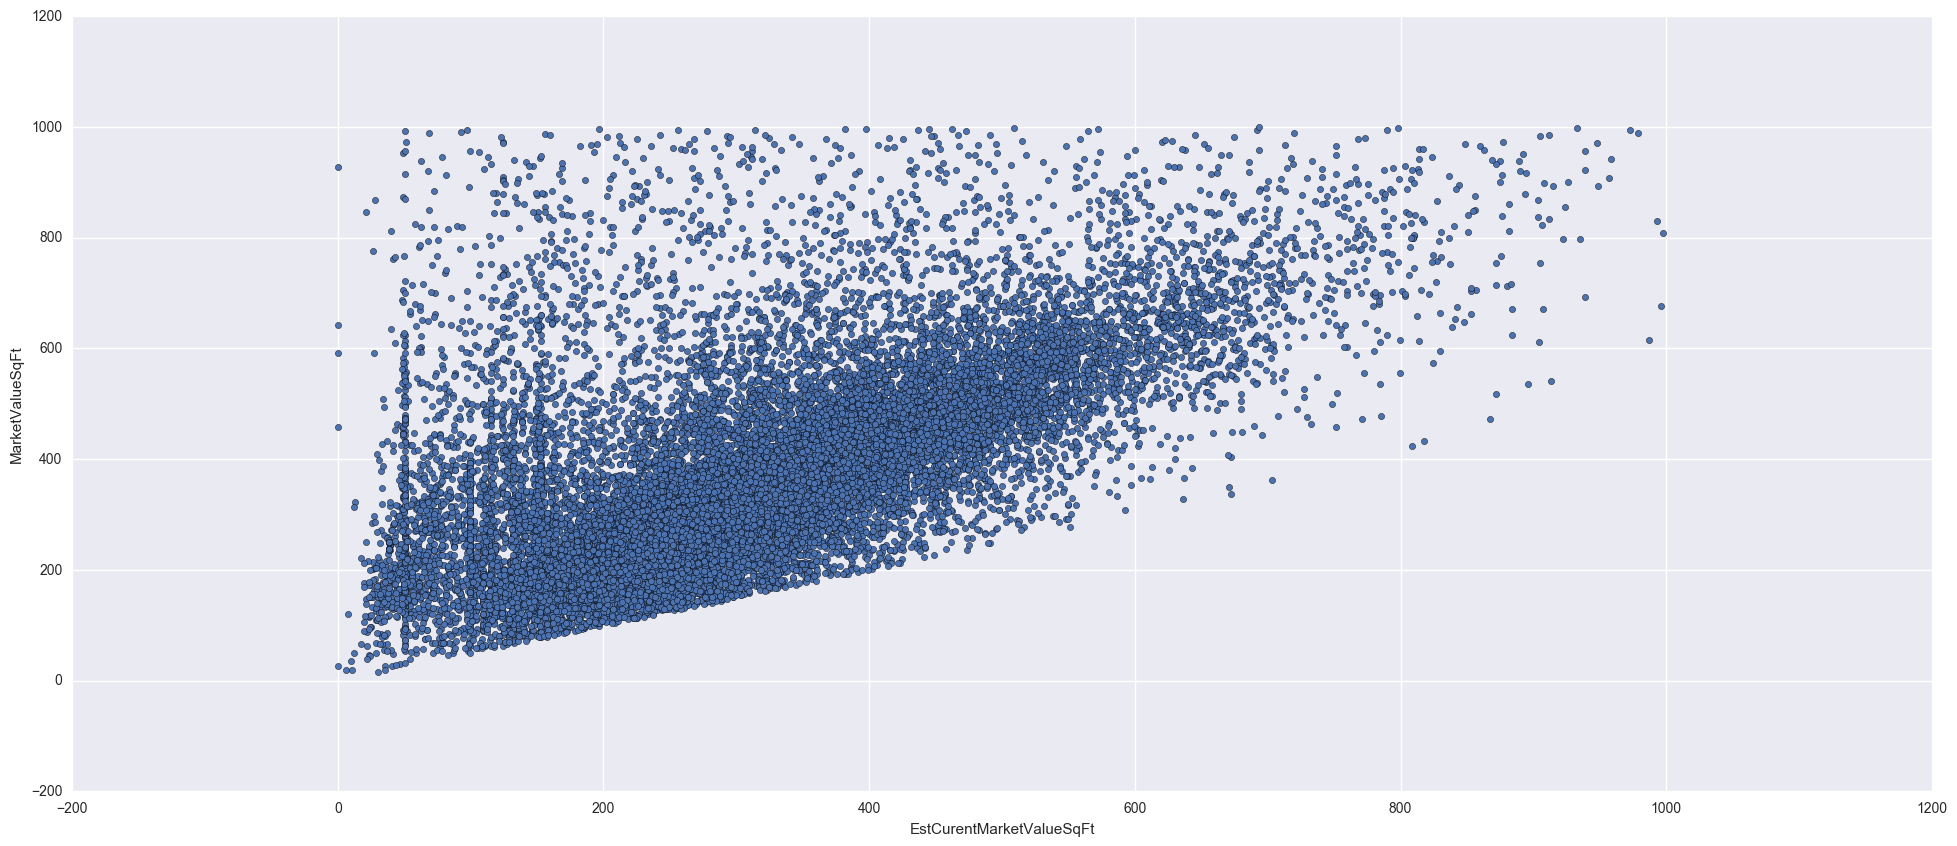

In [26]:
r_p_pre_ss[['MarketValueSqFt', 'EstCurentMarketValueSqFt']].plot(y='MarketValueSqFt',
                                                                 x='EstCurentMarketValueSqFt',
                                                                 kind='scatter',
                                                                 figsize=(24, 10))

Again, what this is: non-apartment property sales where (1) the ratio between the market value estimate and actual value estimate is less than a factor 2 and (2) the value of both the sale and the estimate is less than 1000$.

This picture contains 90 percent of our data points.

In [27]:
len(r_p_pre_ss) / len(r_p_pre)

0.9017670530115903

However, it's still not great. Notice how there are structural "lines" at 50, 100, and 150 dollars? These appear standardized assessment price values for unimproved land of some kind, which are patently incorrect in light of the market value because the land was, for example, built upon in that time.

I want to capture the really tight band around the line of best fit. We can do this by fitting our own pair of parabolas!

These were computed by hand using a pair of systems of three variables. The bottom parabola:

$$x, y = (0, 0)$$
$$x, y = (1000, 1000)$$
$$x, y = (400, 200)$$

The top parabola:

$$x, y = (0, 0)$$
$$x, y = (1000, 1000)$$
$$x, y = (200, 375)$$

In [28]:
import matplotlib.pyplot as plt

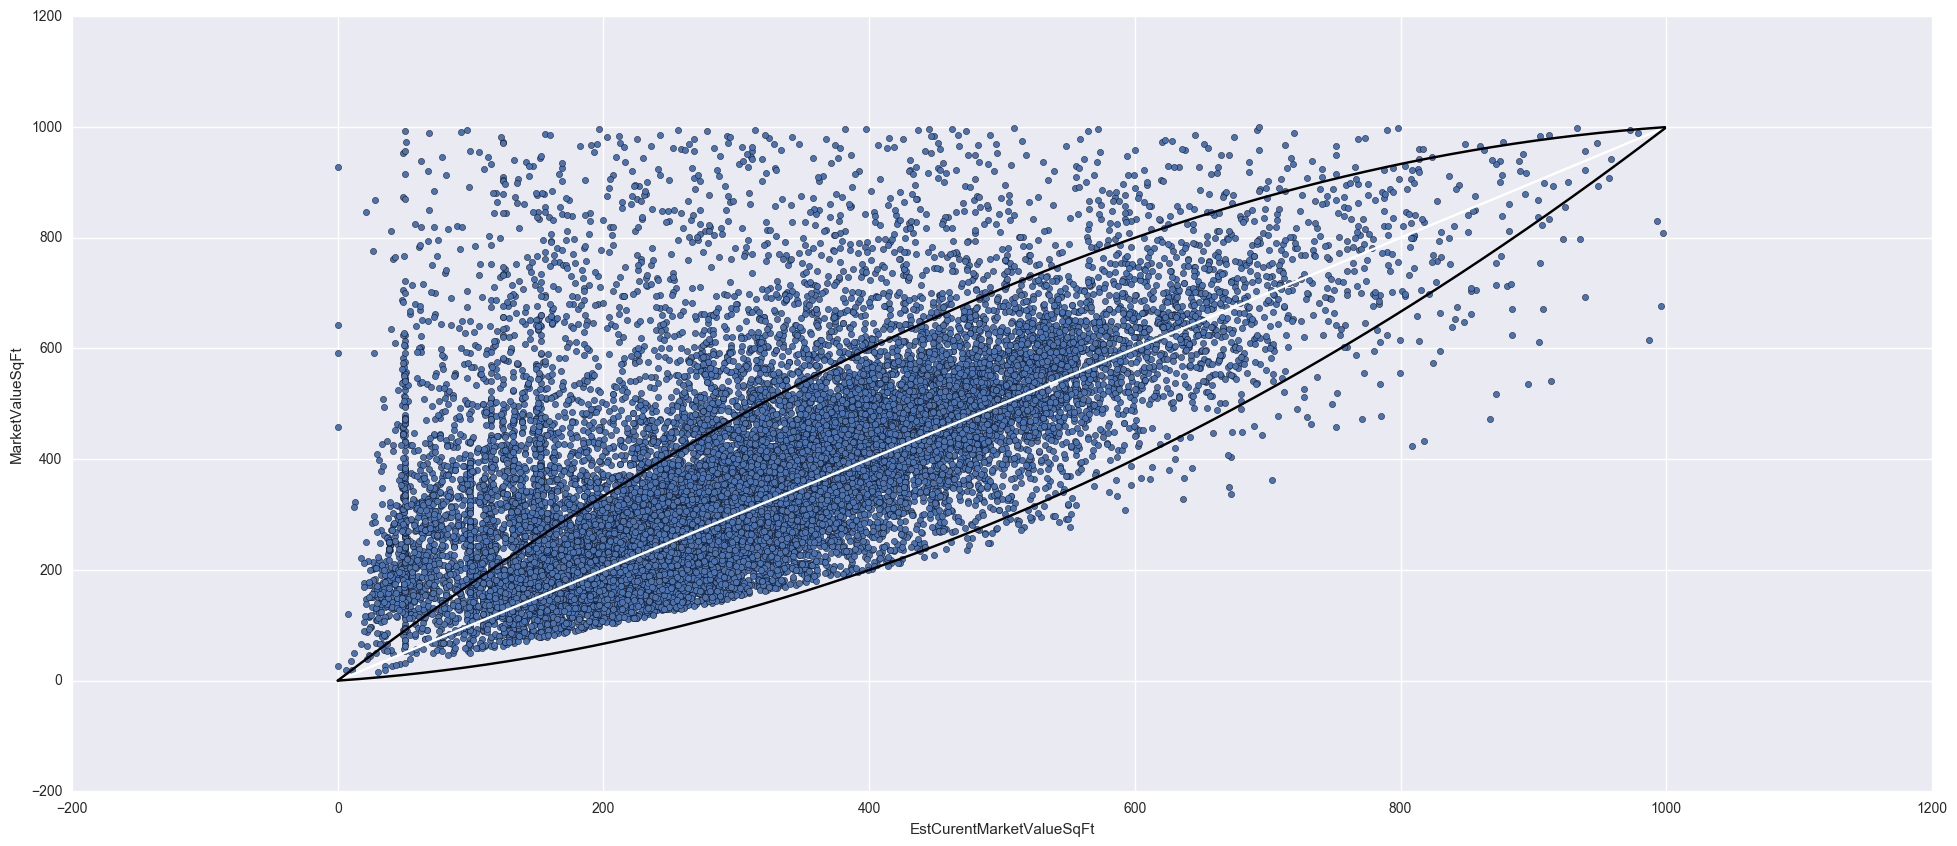

In [29]:
r_p_pre_ss[['MarketValueSqFt', 'EstCurentMarketValueSqFt']].plot(y='MarketValueSqFt',
                                                                 x='EstCurentMarketValueSqFt',
                                                                 kind='scatter',
                                                                 figsize=(24, 10))
plt.plot([a for a in range(0, 1000)], [a for a in range(0, 1000)], color='white')
plt.plot([a for a in range(0, 1000)], [0.000833*x**2 + 0.1666*x for x in range(0, 1000)], color='black') 
plt.plot([a for a in range(0, 1000)], [-0.00083333333*x**2 + 1.8333*x for x in range(0, 1000)], color='black') 
# todo: how can fit a parabola!

In [30]:
def is_likely_sale(srs):
    mval = srs['MarketValueSqFt']
    e_val = srs['EstCurentMarketValueSqFt']
    return -0.00083333333*e_val**2 + 1.8333*e_val > mval > 0.000833*e_val**2 + 0.1666*e_val

likely_sales = r_p_pre_ss[r_p_pre_ss.apply(is_likely_sale, axis='columns')]

In [31]:
len(likely_sales)

19267

In [32]:
len(r_p_pre_ss)

23730

In [33]:
len(likely_sales) / len(r_p_pre_ss)

0.8119258322798146

At this point we've retained just under three quarters of the records from our original sales data.

In [34]:
len(likely_sales) / len(r_p_pre)

0.7321679650389512

Here is what our points now look like:

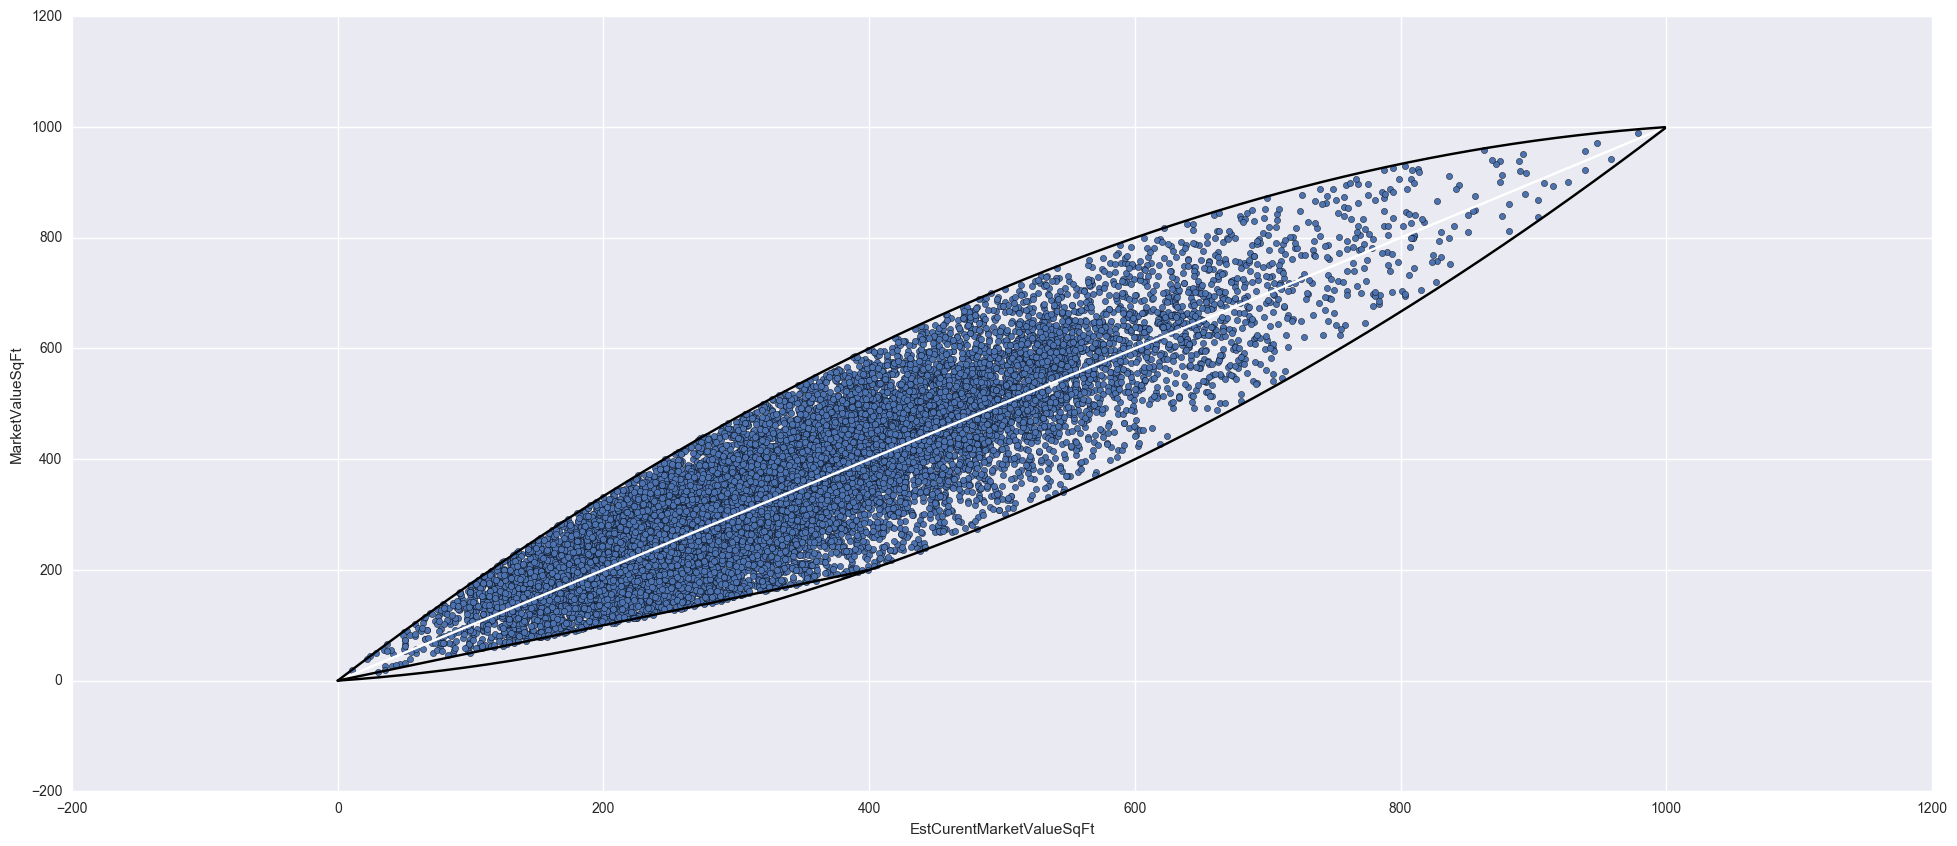

In [35]:
likely_sales[['MarketValueSqFt', 'EstCurentMarketValueSqFt']].plot(y='MarketValueSqFt',
                                                                 x='EstCurentMarketValueSqFt',
                                                                 kind='scatter',
                                                                 figsize=(24, 10))
plt.plot([a for a in range(0, 1000)], [a for a in range(0, 1000)], color='white')
plt.plot([a for a in range(0, 1000)], [0.000833*x**2 + 0.1666*x for x in range(0, 1000)], color='black') 
plt.plot([a for a in range(0, 1000)], [-0.00083333333*x**2 + 1.8333*x for x in range(0, 1000)], color='black')
plt.plot([a for a in range(0, 400)], [x*0.5 for x in range(0, 400)], color='black')

These are the points we will use to build the model.

In [36]:
likely_sales = likely_sales[r_p_pre.columns]

In [37]:
!mkdir "..\data\processed

A subdirectory or file ..\data\processed already exists.


In [38]:
likely_sales.to_csv("../data/processed/likely_sales.csv")